In [ ]:
import json
import os
import numpy as np
import scipy.ndimage
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random

# Define base directory for your data
base_dir = 'k:/HSI/'

# Load the JSON files
def load_data(file_path):
    with open(file_path) as f:
        return json.load(f)

data_train = load_data('k:/HSI/train_only_labeled_v2.json')

# Map ripeness states to numerical labels
ripeness_map = {
    "unripe": 0,
    "perfect": 1,
    "overripe": 2
}

# Function to read the binary data
def read_bin_file(bin_file_path, hdr_file_path):
    try:
        with open(hdr_file_path, 'r') as f:
            for line in f:
                if "samples" in line:
                    width = int(line.split('=')[-1].strip())
                elif "lines" in line:
                    height = int(line.split('=')[-1].strip())
                elif "bands" in line:
                    bands = int(line.split('=')[-1].strip())

        bin_path = os.path.join(base_dir, bin_file_path)
        with open(bin_path, 'rb') as f:
            data = np.fromfile(f, dtype=np.float32)
        data = data.reshape((height, width, bands))
        
        return data
    
    except FileNotFoundError as e:
        print(f"File not found: {e.filename}")
        return None

# Function to resize hyperspectral data to a consistent shape
def resize_hyperspectral_data(data, target_shape=(64, 64, 224)):
    current_shape = data.shape
    if current_shape != target_shape:
        zoom_factors = [target_shape[i] / current_shape[i] for i in range(3)]
        resized_data = scipy.ndimage.zoom(data, zoom_factors, order=1)
        return resized_data
    return data

# Function to extract features and labels
def extract_features_and_labels(data, annotations_dict, X_list, y_ripeness_list):
    for record in data['records']:
        if record['fruit'].lower() == "kaki":
            bin_file = record['files']['data_file']
            hdr_file = record['files']['header_file']
            record_id = record['id']
            
            # Load and resize hyperspectral data
            hyperspectral_data = read_bin_file(bin_file, hdr_file)
            if hyperspectral_data is None:
                continue
            
            hyperspectral_data = resize_hyperspectral_data(hyperspectral_data)
            X_list.append(hyperspectral_data)

            # Get ripeness annotation
            if record_id in annotations_dict:
                ripeness_state = annotations_dict[record_id]['ripeness_state']
                y_ripeness_list.append(ripeness_map[ripeness_state])
            else:
                print(f"Warning: No annotation found for record_id {record_id}")

# Prepare training data
annotations_dict_train = {annot['record_id']: annot for annot in data_train['annotations']}
X, y_ripeness = [], []
extract_features_and_labels(data_train, annotations_dict_train, X, y_ripeness)

# Convert to numpy arrays
X = np.array(X)
y_ripeness = np.array(y_ripeness)

# One-hot encode the ripeness labels
y_ripeness = to_categorical(y_ripeness, num_classes=3)

# Function to augment a single hyperspectral image by applying random transformations
def augment_image(data):
    if random.choice([True, False]):
        data = np.flip(data, axis=0)  # Flipw
    if random.choice([True, False]):
        data = np.flip(data, axis=1)  # Flip horizontally
    if random.choice([True, False]):
        data = scipy.ndimage.rotate(data, angle=random.randint(-20, 20), axes=(0, 1), reshape=False)
    if random.choice([True, False]):
        shift = random.uniform(-0.1, 0.1)
        data = scipy.ndimage.shift(data, shift=[shift, shift, 0], mode='nearest')
    
    return data

# Function to balance classes using augmentation
def balance_classes(X, y, target_count=84):
    X_balanced, y_balanced = [], []
    for class_label in range(3):  # For each class label
        class_indices = np.where(np.argmax(y, axis=1) == class_label)[0]
        current_count = len(class_indices)
        print("i am in")
        # Add original samples for the class
        for idx in class_indices:
            X_balanced.append(X[idx])
            y_balanced.append(y[idx])
        
        # Generate augmented samples if the current count is less than the target count
        if current_count < target_count:
            augment_needed = target_count - current_count
            for _ in range(augment_needed):
                original = X[random.choice(class_indices)]
                augmented = augment_image(original)
                X_balanced.append(augmented)
                y_balanced.append(to_categorical(class_label, num_classes=3))
    
    return np.array(X_balanced), np.array(y_balanced)

# Balance the classes
target_count = max(np.count_nonzero(y_ripeness == 1), 84)  # Setting target as the highest count among classes
X_balanced, y_balanced = balance_classes(X, y_ripeness, target_count=target_count)
print(y_balanced)
# Train-test split on the balanced dataset
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Print the shapes to verify
print("Shapes after balancing:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)


i am in
i am in
i am in
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Shapes after balancing:
X_train: (268, 64, 64, 224)
y_train: (268, 3)
X_val: (68, 64, 64, 224)
y_val: (68, 3)


C:\Users\kpoff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape               ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv2d (SeparableConv2D)  │ (None, 64, 64, 25)         │           7,641 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ average_pooling2d                   │ (None, 16, 16, 25)         │               0 │
│ (AveragePooling2D)                  │                            │                 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batch_normalization                 │ (None, 16, 16, 25)         │             100 │
│ (BatchNormalization)                │                            │                 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ separable_conv2d_1                  │ (None, 16, 16, 30)         │           1,005 │
│ (SeparableConv2D)                   │                            │                 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ average_pooling2d_1                 │ (None, 4, 4, 30)           │               0 │
│ (AveragePooling2D)                  │                            │                 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batch_normalization_1               │ (None, 4, 4, 30)           │             120 │
│ (BatchNormalization)                │                            │                 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ separable_conv2d_2                  │ (None, 4, 4, 50)           │           1,820 │
│ (SeparableConv2D)                   │                            │                 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batch_normalization_2               │ (None, 4, 4, 50)           │             200 │
│ (BatchNormalization)                │                            │                 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ global_average_pooling2d            │ (None, 50)                 │               0 │
│ (GlobalAveragePooling2D)            │                            │                 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batch_normalization_3               │ (None, 50)                 │             200 │
│ (BatchNormalization)                │                            │                 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dense (Dense)                       │ (None, 25)                 │           1,275 │
├─────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                     │ (None, 3)                  │              78 │
└─────────────────────────────────────┴────────────────────────────┴─────────────────┘

 Total params: 12,439 (48.59 KB)

 Trainable params: 12,129 (47.38 KB)

 Non-trainable params: 310 (1.21 KB)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.4403 - loss: 1.1134 - val_accuracy: 0.2941 - val_loss: 1.2358
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4350 - loss: 0.9895 - val_accuracy: 0.2941 - val_loss: 1.2278
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4782 - loss: 0.9450 - val_accuracy: 0.2941 - val_loss: 1.2203
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5558 - loss: 0.8602 - val_accuracy: 0.2941 - val_loss: 1.2156
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6318 - loss: 0.8133 - val_accuracy: 0.2941 - val_loss: 1.2114
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7203 - loss: 0.7699 - val_accuracy: 0.2941 - val_loss: 1.2082
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7261 - loss: 0.7554 - val_accuracy: 0.2941 - val_loss: 1.2053
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7515 - loss: 0.7368 - val_accuracy: 0.

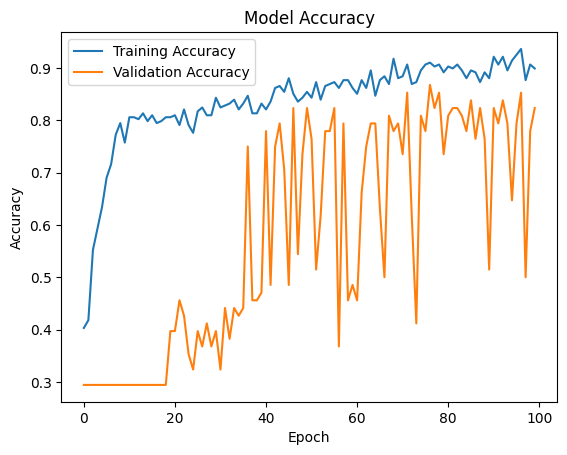

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define the model structure based on your provided architecture
def create_custom_hs_cnn(input_shape):
    model = Sequential()
    
    # First Depthwise Separable Conv2D block
    model.add(SeparableConv2D(25, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(AveragePooling2D(pool_size=(4, 4)))
    model.add(BatchNormalization())
    
    # Second Depthwise Separable Conv2D block
    model.add(SeparableConv2D(30, (3, 3), activation='relu', padding='same'))
    model.add(AveragePooling2D(pool_size=(4, 4)))
    model.add(BatchNormalization())
    
    # Third Depthwise Separable Conv2D block
    model.add(SeparableConv2D(50, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    
    # Global Average Pooling and Batch Normalization
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    
    # Output layer with 25-dimensional feature space
    model.add(Dense(25, activation='sigmoid'))  # To match the output dimension
    
    # Final classification layer with 3 units (for 3 classes)
    model.add(Dense(3, activation='softmax'))
    
    return model

# Define the input shape based on the all bands
input_shape = (64, 64, 224)  # total_bands is the total number of hyperspectral bands

# Learning rate
lr = 0.0001

# Create and compile the model
model = create_custom_hs_cnn(input_shape)
model.compile(optimizer=Adam(learning_rate=lr), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Model summary to verify architecture
model.summary()

# Number of epochs
epochs = 100

# Early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=16,
    validation_data=(X_val, y_val),
    # callbacks=[early_stopping],
    verbose=1
)

# Save the model
model.save('hyperspectral_cnn_model_' + f'{epochs}' + '_' + f'{lr}' + '.h5')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


In [ ]:
image_path = 'K:/HSI/Kaki/VIS_COR/day_1_m3/kaki_day_1_m3_04_back.bin'
hdr_file = 'K:/HSI/Kaki/VIS_COR/day_1_m3/kaki_day_1_m3_04_back.hdr'
hyperspectral_data = read_bin_file(image_path, hdr_file)
image = resize_hyperspectral_data(hyperspectral_data)
image = np.expand_dims(image, axis=0)  
ripness = model.predict(image)
ripness=ripness[0]
print(ripness)
max_index = np.argmax(ripness)
index_to_ripeness = {v: k for k, v in ripeness_map.items()}
ripeness_label = index_to_ripeness[max_index]
print("Predicted ripeness:", ripeness_label) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[0.11973111 0.75078017 0.1294887 ]
Predicted ripeness: perfect


In [6]:
from sklearn.metrics import classification_report
import numpy as np

# Predict class probabilities for the validation set
y_val_pred_probs = model.predict(X_val)
# Get the predicted class labels by taking the argmax (index of the highest probability)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Convert one-hot encoded labels back to single labels
y_val_true = np.argmax(y_val, axis=1)

# Generate the classification report
class_names = ['Unripe', 'Perfect', 'Overripe']  # Your class labels
report = classification_report(y_val_true, y_val_pred, target_names=class_names, output_dict=True)

# Print the accuracy for each class
print("Accuracy for each class:")
for class_name, metrics in report.items():
    if class_name in class_names:  # Only print for actual classes, not overall metrics
        print(f"{class_name}: {metrics['precision'] * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 
Accuracy for each class:
Unripe: 86.67%
Perfect: 75.00%
Overripe: 81.82%


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


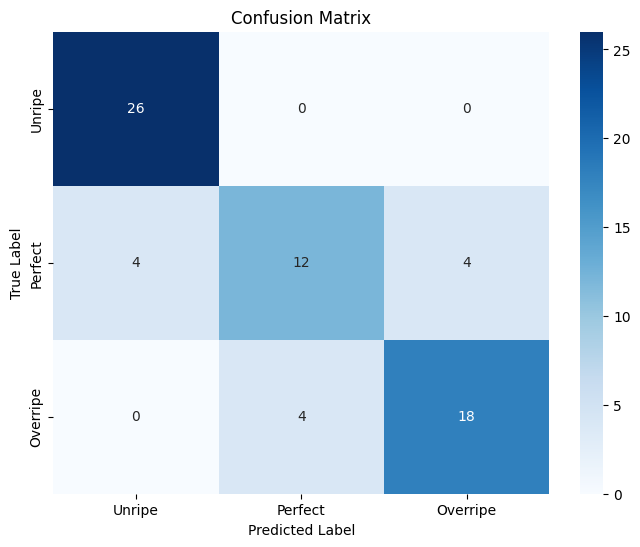

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict class labels for the validation set
y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred)

# Define class names for the matrix labels (adjust as needed)
class_names = ['Unripe', 'Perfect', 'Overripe']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
